# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

The `detect` function below accepts a file path to an image and first determines whether the image contains a human, dog, or neither. Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [1]:
# Import all dependencies in one shot
import numpy as np
import torch
import torchvision.models as models
import torch.nn as nn
import random, os
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import cv2                
import matplotlib.pyplot as plt
from torchvision import datasets
from glob import glob
from PIL import Image
from PIL import ImageFile                   
%matplotlib inline         

In [2]:
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# Can we use the GPU?
use_cuda = torch.cuda.is_available()
print("Using " + "GPU" if use_cuda else "CPU")

Using GPU


## Human Face Detector

Let's create a human face detector using a pre-trained Haar Cascade network.

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# The following returns `true` if a human face was detected in the image
def human_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Let's test our human face detector.

In [5]:
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

print("Human image is detected as human? " + str(human_detector(human_files[0])))
print("Dog image is detected as human? " + str(human_detector(dog_files[0])))

Human image is detected as human? True
Dog image is detected as human? False


## VGG16 Dog Detector

Let's create a dog detector using a pre-trained VGG16 network.

In [6]:
## Specify dog image data loaders

training_images_path   = '/data/dog_images/train'
test_images_path       = '/data/dog_images/test'
validation_images_path = '/data/dog_images/valid'

## Define / Count Classes
classes = os.listdir(training_images_path)
print("Found " + str(len(classes)) + " dog breeds")

batch_size = 20
num_workers = 0

# Training transforms should manipulate/skew, rotate, etc the image to make it harder
train_transforms = transforms.Compose([transforms.Resize((256,256)),
                                       transforms.RandomAffine(10, (0.05, 0.05), (0.9, 0.9), 0.1, resample=False, fillcolor=0),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.RandomResizedCrop(224),
                                       transforms.ColorJitter(0.1, 0.1, 0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

# Test transforms should just scale the images
test_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                     ])

train_data = datasets.ImageFolder(training_images_path, transform=train_transforms)
test_data  = datasets.ImageFolder(test_images_path, transform=test_transforms)
valid_data = datasets.ImageFolder(validation_images_path, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

loaders_transfer = dict(train=train_loader,
                        valid=valid_loader,
                        test=test_loader)

Found 133 dog breeds


In [7]:
## Boolean dog detector using a pre-trained VGG16 CNN

# Load a pre-trained VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

vgg16_img_size = 224 # vgg16 is trained on 224x224 images
transform_pipeline = transforms.Compose([transforms.Resize(vgg16_img_size),
                                         transforms.CenterCrop(vgg16_img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    img = Image.open(img_path)
    img_t = transform_pipeline(img)
    img_t = img_t.unsqueeze(0)
    
    if use_cuda:
        img_t = img_t.cuda()
        
    VGG16.eval() # put model in eval mode
    probabilities = VGG16(img_t)
    index = probabilities.cpu().data.numpy().argmax()
    
    return index

In [8]:
# Define our dog detector
def dog_detector(img_path):
    class_prediction = VGG16_predict(img_path)
    # 151 = Chihuahua
    # 268 = Mexican hairless
    # 151-268 = dogs # @see https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    return 151 <= class_prediction <= 268

Let's test our dog detector.

In [9]:
print("Human image is detected as dog? " + str(dog_detector(human_files[0])))
print("Dog image is detected as dog? " + str(dog_detector(dog_files[0])))

Human image is detected as dog? False
Dog image is detected as dog? True


## ResNet50 Dog Breed Classifier

Train and validate a dog breed detection model using a pre-trained ResNet50 CNN.

In [10]:
model_transfer = models.resnet50(pretrained=True)

# Freeze model params
for param in model_transfer.parameters():
    param.requires_grad = False

# Replace the fully-connected layer with one that outputs classes equal to our dog breeds, and unfreeze for training
model_transfer.fc = nn.Linear(model_transfer.fc.in_features, len(classes), bias=True)    
for param in model_transfer.fc.parameters():
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [11]:
criterion_transfer = nn.CrossEntropyLoss()
## Couldn't get the Adam optimizer working with ResNet50
# optimizer_transfer = optim.Adam(model_scratch.parameters(), lr=0.005)
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

In [12]:
# Define our training function
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

### Train the ResNet50 Model

Save the pre-trained model to `model_trainsfer.pt`.

In [13]:
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.842063 	Validation Loss: 4.702467
Validation loss decreased (inf --> 4.702467).  Saving model ...
Epoch: 2 	Training Loss: 4.657440 	Validation Loss: 4.499068
Validation loss decreased (4.702467 --> 4.499068).  Saving model ...
Epoch: 3 	Training Loss: 4.502385 	Validation Loss: 4.306547
Validation loss decreased (4.499068 --> 4.306547).  Saving model ...
Epoch: 4 	Training Loss: 4.358809 	Validation Loss: 4.132617
Validation loss decreased (4.306547 --> 4.132617).  Saving model ...
Epoch: 5 	Training Loss: 4.219584 	Validation Loss: 3.948636
Validation loss decreased (4.132617 --> 3.948636).  Saving model ...
Epoch: 6 	Training Loss: 4.079968 	Validation Loss: 3.791606
Validation loss decreased (3.948636 --> 3.791606).  Saving model ...
Epoch: 7 	Training Loss: 3.949412 	Validation Loss: 3.612335
Validation loss decreased (3.791606 --> 3.612335).  Saving model ...
Epoch: 8 	Training Loss: 3.829192 	Validation Loss: 3.468457
Validation loss decreased (3.61233

In [14]:
# Load our trained model
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Test Our Trained ResNet50 Model

In [19]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [20]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.126275


Test Accuracy: 67% (565/836)


## Predict Dog Breeds

Let's create a function to predict dog breeds using our pre-trained network.

In [21]:
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def dog_breed_predictor(img_path):    
    # Open the image
    image = Image.open(img_path).convert('RGB')
    # Normalize the image
    predict_transforms = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = predict_transforms(image).unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    # Make sure our model is in eval mode
    model_transfer.eval()
    
    i = torch.argmax(model_transfer(image))
    return class_names[i]

# Combine Detectors

Cobine our `human_detector`, `dog_detector`, and `dog_breed_predictor` into a single function that detects whether an image is a human or dog, and outputs the predicted dog breed.

In [22]:
def detect(img_path):
    img = cv2.imread(img_path)
    ## Show the image
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    ## handle cases for a human face, dog, and neither
    human_detected = human_detector(img_path)
    dog_detected = dog_detector(img_path)
    dog_class = dog_breed_predictor(img_path)
    
    if human_detected:
        print("Hello, human! You look a bit like a " + dog_class.lower() + ".")
    elif dog_detected:
        print("Hello, " + dog_class.lower() + "! Who's a good doggy!?")
    else:
        print("What are you!?")


---
# Test the Algorithm

Let's take our new algorithm for a spin on some test images!



Classifying: images/test/shutterstock_648907024.jpg


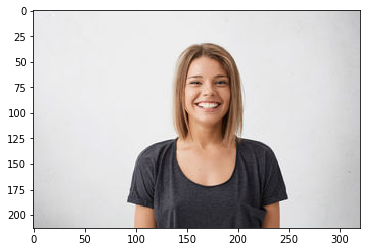

Hello, human! You look a bit like a affenpinscher.


Classifying: images/test/photo-1568564321589-3e581d074f9b.jpeg


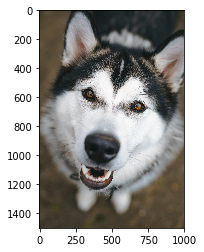

Hello, alaskan malamute! Who's a good doggy!?


Classifying: images/test/black-chiweenie-royalty-free-image-511504986-1563378924.jpg


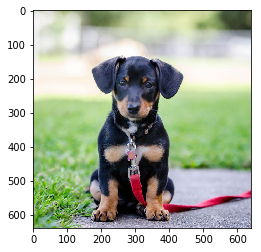

Hello, entlebucher mountain dog! Who's a good doggy!?


Classifying: images/test/gettyimages-1094874726.png


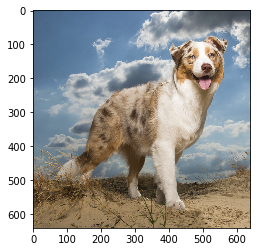

Hello, brittany! Who's a good doggy!?


Classifying: images/test/golden-retriever-puppy.jpg


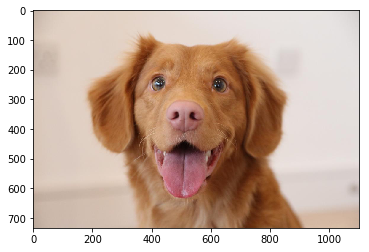

Hello, human! You look a bit like a nova scotia duck tolling retriever.


Classifying: images/test/1000x-1.jpg


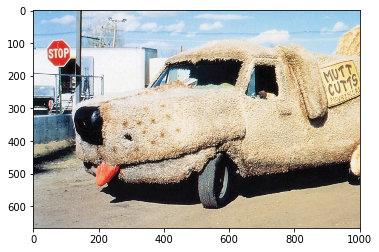

What are you!?


Classifying: images/test/94665_0.jpg


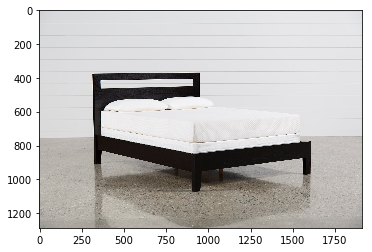

Hello, human! You look a bit like a chesapeake bay retriever.


Classifying: images/test/a6923adbc7bece73803221613f410782.jpeg


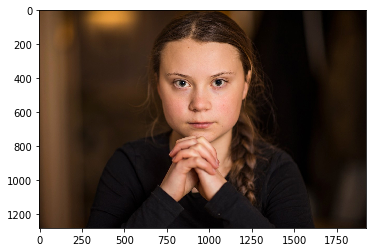

Hello, human! You look a bit like a maltese.


Classifying: images/test/embark-bulldog-dog-person.jpg


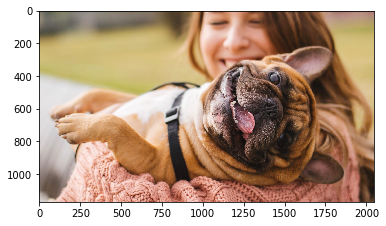

Hello, dogue de bordeaux! Who's a good doggy!?


Classifying: images/test/merlin_159579261_79946c8d-cc7b-49ea-a5de-bbf3676480c2-articleLarge.jpg


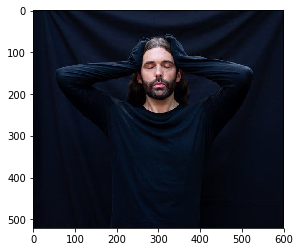

Hello, human! You look a bit like a maltese.


Classifying: images/test/1078702682_6004950245001_6004956161001-vs.jpg


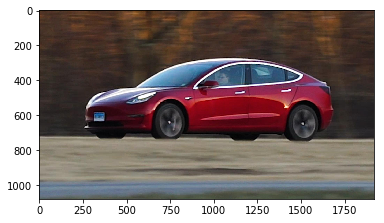

What are you!?


Classifying: images/test/Weimaraner-puppy-outdoors-with-bright-blue-eyes.20190813165758508-1.jpg


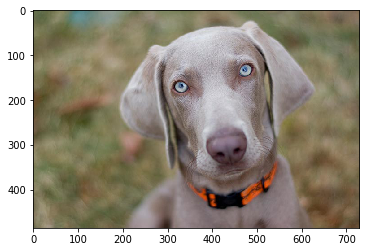

Hello, chesapeake bay retriever! Who's a good doggy!?


Classifying: images/test/smartest-dog-breeds-1553287693.jpg


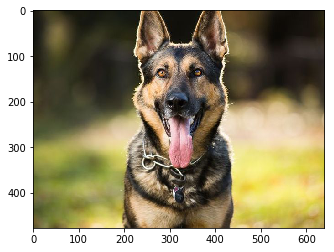

Hello, german shepherd dog! Who's a good doggy!?


Classifying: images/test/105992231-1561667465295gettyimages-521697453.jpeg


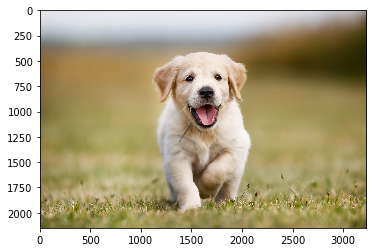

Hello, golden retriever! Who's a good doggy!?


Classifying: images/test/billgates.jpg


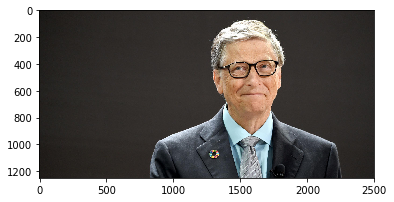

What are you!?


Classifying: images/test/keanu-reeves-person-of-the-year-karwai-tang-getty.jpg


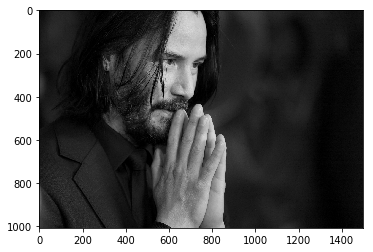

What are you!?


Classifying: images/test/p07zn7p7.jpg


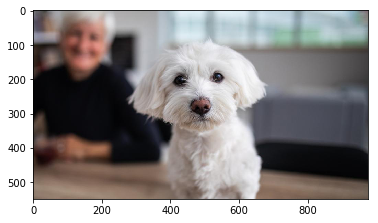

Hello, maltese! Who's a good doggy!?


Classifying: images/test/webmd_rf_photo_of_cat_and_dog_people.jpg


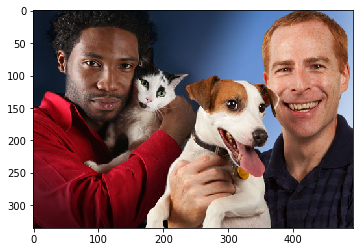

Hello, human! You look a bit like a beagle.


Classifying: images/test/106069136-1565284193572gettyimages-1142580869.jpeg


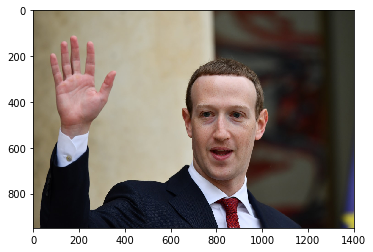

Hello, human! You look a bit like a bull terrier.


In [23]:
# Execute the algorithm on some test images
from glob import glob

# Load some test images
pics = np.array(glob("images/test/*"))
for file_path in pics:
    print()
    print()
    print("Classifying: " + file_path)
    detect(file_path)

# Results

The output is about what I expected, or maybe a bit worse. I'm surprised that it classified a bed as a human rather than nothing.

Three ways I would improve the algorithm are:

1. Train it for much, _much_ longer, on a _much_ larger dataset. This would certainly yield better results.
2. More aggressive random transformations during training would likely improve the accuracy.
3. Do a more serious evaluation about whether a ResNet-based model is the absolute best approach here. Some quick searching seems to point to DenseNet (which is ResNet-derived) as being slightly better performing (but more memory-hungry). [See here](https://arxiv.org/abs/1608.06993).